Now as a project, we'll experiment with recurrent networks and learn a *language model*. A language model is simply a network that predicts the next word or character when trained on a set of data. 

We'll train James Joyce' *Ulysses*.

In [2]:
import numpy as np
import keras
from keras.layers import LSTM, BatchNormalization, CuDNNLSTM, Dense, Dropout, Embedding, Reshape
from keras.models import Sequential, Model

from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

I've downloaded the text from Project Gutenberg, which is a great source of free texts of classic works.

In [4]:
with open("ulysses.txt", 'r', encoding='utf8') as f:
    text_content = f.read().lower()

Now, we cannot exactly use text as is, we need to turn it into numbers. To do this, we'll use the `Tokenizer` to generate word to number mappings.

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text_content])

Now we have a list of numbers rather than a string of characters.

In [4]:
ordinals = tokenizer.texts_to_sequences([text_content])[0]
ordinals[0:10]

[13931, 1, 293, 292, 2236, 2, 2447, 22, 827, 5448]

Hmm -- how many unique words did we find?

In [5]:
unique_tokens = len(tokenizer.word_index) + 1

OK -- working with sequences, we need something to predict. That will be -- the next word. So, for any given sequence of a given length, the next word from the source text will be the output. This means we'll be taking out one hot array and chopping it into sequences for input, and single words as output.


In [6]:
sequence_length = 32
# make sure we don't go past the end of the sequence or ordinals
chunks = len(ordinals) - sequence_length
# sequence numbers for context words
inputs = np.zeros((chunks, sequence_length), dtype=np.int32)
# one hot encodings for target words
outputs = np.zeros((chunks, unique_tokens), dtype=np.float)
for i in range(0, chunks):
    # copy in the ordinal word numbers for a sequence or words
    context = np.array(ordinals[i:i+sequence_length], dtype=np.int32)
    inputs[i] = context
    #one hot flags the single word
    target = ordinals[i+sequence_length]
    outputs[i, target] = 1

Each string will need to be in a matrix, and formulated as a 'batch'. We'll space pre-pad, and trim as needed to make sure we are the correct sequence length for our model.

These encoding and decoding functions will turn our model into usable text.

In [7]:
def encode_string(s, max_len=sequence_length):
    # only to max length
    ret = np.zeros((max_len,), dtype=np.int32)
    # actual encoding
    ordinals = tokenizer.texts_to_sequences([s])[0][-max_len:]
    encoded = np.array(ordinals, dtype=np.int32)
    # take the 'tail' of the encoded and keep it
    ret[-len(encoded):] = encoded
    # formulate this into a very mini batch, only one batch entry
    return np.expand_dims(ret, axis=0)

In [8]:
encode_string('Can we have')

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 128,  70,  42]], dtype=int32)

In [9]:
def decode_string(model_output):
    return tokenizer.sequences_to_texts([[model_output.argmax().astype(np.int32)]])

In [10]:
decode_string(outputs[0])

['give']

Now we'll make a keras callback, so we can watch text generation at each epoch as the model learns. Callbacks are a nice way to 'see inside' keras while it is running.

In [11]:
class Generate(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        text = 'Can we have'
        for i in range(32):
            output = self.model.predict(encode_string(text))
            next_word = decode_string(output)[0]
            text += ' {0}'.format(next_word)
        print(text)

Now we'll do a bit more advanced learning -- and make a network that can encode and decode a recurrent string network.

This starts with embedding the integer representing each word -- this turns an index of a single word into a floating point array better suited for machine learning. Then we run a recurrent network -- it loops over each word position, feeding the network into itself on each step. 

The next part of the stack is a standard multilayer perceptron. Here we're using the `elu` activation. This differs from a `relu` in that is will allow some negative values, where a `relu` is always zero for negative inputs.

Finally, we do a dense output to generate one hot encodings for outputs via `softmax`.

We're going to use Adam, since we had great learning results with it earlier -- it's a pretty good default. 

In [12]:
number_embedding_layers = 256
number_hidden_layers = 256
number_layers = 2
epochs = 32
batch_size = 32

model = Sequential()
# begin by embedding character positions
model.add(Embedding(unique_tokens,
                    number_embedding_layers, 
                    input_shape=(inputs.shape[1],)))
# and then work on the embeddings recurrently
model.add(LSTM(number_hidden_layers, unroll=True))
model.add(Dense(number_hidden_layers, activation='elu'))
model.add(Dense(number_hidden_layers, activation='elu'))
model.add(Dense(outputs.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
results = model.fit(inputs, outputs, epochs=epochs, batch_size=batch_size, callbacks=[Generate()])

Epoch 1/32
268414/268414 [==============================] - 536s 2ms/step - loss: 7.3406
Can we have been been in the world of the world of the world of the world of the world of the world of the world of the world of the world of the world
Epoch 2/32
268414/268414 [==============================] - 481s 2ms/step - loss: 6.6730
Can we have a good man of the world the other time of the world and the other time the other time i was a good man and the other time i was a good
Epoch 3/32
268414/268414 [==============================] - 480s 2ms/step - loss: 6.3067
Can we have forgotten to see the same for the same for the same for the same for the same place for the same place and the same time and the same time and the
Epoch 4/32
268414/268414 [==============================] - 480s 2ms/step - loss: 5.8960
Can we have a good man of course he is in the dark and the last time they are all the same time they say he was in the same time he had the last
Epoch 5/32
268414/268414 [===============

In [13]:
def plot_loss(total_loss):
    x_axis = np.linspace(0, len(total_loss), len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

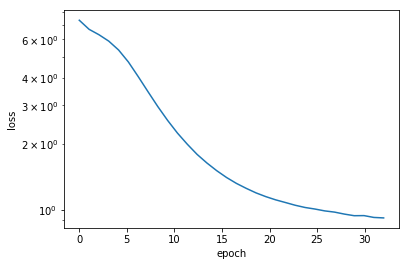

In [16]:
plot_loss(results.history['loss'])

We can see the loss keeps declining -- training for more epochs can certainly generate more learning.